In [20]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

In [21]:
CLASS_NUM = 21
BATCH_SIZE = 16
EPOCH_STEPS = int(4323/BATCH_SIZE)
IMAGE_SHAPE = (256, 256, 3)
MODEL_NAME = 'googlenet_ucm.h5'

In [22]:
datagen = ImageDataGenerator()
train_it = datagen.flow_from_directory('archive/images_train_test_val/train/', target_size=(256, 256), batch_size=32, class_mode='categorical')
val_it = datagen.flow_from_directory('archive/images_train_test_val/validation/', target_size=(256, 256), batch_size=32, class_mode='categorical')
test_it = datagen.flow_from_directory('archive/images_train_test_val/test/', target_size=(256, 256), batch_size=32, class_mode='categorical')

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


In [23]:
# create model
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


In [24]:
def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer



In [25]:
def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model
    

In [26]:
# train model
model = googlenet()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_118 (Conv2D)            (None, 128, 128, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_26 (MaxPooling2D  (None, 64, 64, 64)  0           ['conv2d_118[0][0]']             
 )                                                                                          

In [31]:
optimizer = ['Adam', 'SGD', 'Adam', 'SGD']
epochs = [20, 30, 20, 30]
history_all = {}

In [33]:
for i in range(len(optimizer)):
    print('Usnig optimizer: ' + optimizer[i] + ', Epoch: ' + str(epochs[i]))
    
    model.compile(loss='categorical_crossentropy', 
                  loss_weights={'main': 1.0, 'aux1': 0.3, 'aux2': 0.3},
                  optimizer=optimizer[i], metrics=['accuracy'])
    
    train_history = model.fit(
            train_it,
            steps_per_epoch=EPOCH_STEPS,
            epochs=epochs[i],
            #callbacks=[checkpoint]
            shuffle=True,
            validation_data=val_it
            )
    
    # save history    
    if len(history_all) == 0:
        history_all = {key: [] for key in train_history.history}
    
    for key in history_all:
        history_all[key].extend(train_history.history[key])

model.save(MODEL_NAME)


Usnig optimizer: Adam, Epoch: 20
Epoch 1/20


2022-06-12 13:00:54.447301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


230/270 [========================>.....] - ETA: 47s - loss: 3.0736 - main_loss: 1.9624 - aux1_loss: 1.7577 - aux2_loss: 1.9461 - main_accuracy: 0.3257 - aux1_accuracy: 0.4295 - aux2_accuracy: 0.3551WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 5400 batches). You may need to use the repeat() function when building your dataset.


2022-06-12 13:05:32.744978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


270/270 [==============================] - 299s 1s/step - loss: 3.0736 - main_loss: 1.9624 - aux1_loss: 1.7577 - aux2_loss: 1.9461 - main_accuracy: 0.3257 - aux1_accuracy: 0.4295 - aux2_accuracy: 0.3551 - val_loss: 5.7663 - val_main_loss: 3.7892 - val_aux1_loss: 3.2564 - val_aux2_loss: 3.3337 - val_main_accuracy: 0.1190 - val_aux1_accuracy: 0.1352 - val_aux2_accuracy: 0.1243
Usnig optimizer: SGD, Epoch: 30
Epoch 1/30


2022-06-12 13:05:55.429744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


230/270 [========================>.....] - ETA: 50s - loss: 2.3446 - main_loss: 1.5051 - aux1_loss: 1.3252 - aux2_loss: 1.4731 - main_accuracy: 0.4763 - aux1_accuracy: 0.5476 - aux2_accuracy: 0.5035WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 8100 batches). You may need to use the repeat() function when building your dataset.


2022-06-12 13:10:46.792386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


270/270 [==============================] - 314s 1s/step - loss: 2.3446 - main_loss: 1.5051 - aux1_loss: 1.3252 - aux2_loss: 1.4731 - main_accuracy: 0.4763 - aux1_accuracy: 0.5476 - aux2_accuracy: 0.5035 - val_loss: 2.5295 - val_main_loss: 1.5970 - val_aux1_loss: 1.5602 - val_aux2_loss: 1.5482 - val_main_accuracy: 0.4629 - val_aux1_accuracy: 0.4719 - val_aux2_accuracy: 0.4767
Usnig optimizer: Adam, Epoch: 20
Epoch 1/20


2022-06-12 13:11:08.739013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


230/270 [========================>.....] - ETA: 46s - loss: 2.3429 - main_loss: 1.5060 - aux1_loss: 1.3412 - aux2_loss: 1.4485 - main_accuracy: 0.4861 - aux1_accuracy: 0.5531 - aux2_accuracy: 0.5098WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 5400 batches). You may need to use the repeat() function when building your dataset.


2022-06-12 13:15:40.190197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


270/270 [==============================] - 291s 1s/step - loss: 2.3429 - main_loss: 1.5060 - aux1_loss: 1.3412 - aux2_loss: 1.4485 - main_accuracy: 0.4861 - aux1_accuracy: 0.5531 - aux2_accuracy: 0.5098 - val_loss: 2.6032 - val_main_loss: 1.6361 - val_aux1_loss: 1.6022 - val_aux2_loss: 1.6216 - val_main_accuracy: 0.4333 - val_aux1_accuracy: 0.4676 - val_aux2_accuracy: 0.4452
Usnig optimizer: SGD, Epoch: 30
Epoch 1/30


2022-06-12 13:15:59.328829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


230/270 [========================>.....] - ETA: 46s - loss: 1.7269 - main_loss: 1.0930 - aux1_loss: 1.0193 - aux2_loss: 1.0938 - main_accuracy: 0.6137 - aux1_accuracy: 0.6578 - aux2_accuracy: 0.6182WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 8100 batches). You may need to use the repeat() function when building your dataset.


2022-06-12 13:20:31.378157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


270/270 [==============================] - 292s 1s/step - loss: 1.7269 - main_loss: 1.0930 - aux1_loss: 1.0193 - aux2_loss: 1.0938 - main_accuracy: 0.6137 - aux1_accuracy: 0.6578 - aux2_accuracy: 0.6182 - val_loss: 3.0317 - val_main_loss: 1.8582 - val_aux1_loss: 2.0151 - val_aux2_loss: 1.8967 - val_main_accuracy: 0.4419 - val_aux1_accuracy: 0.4067 - val_aux2_accuracy: 0.4267


In [34]:
model.evaluate(test_it, steps=int(4323/BATCH_SIZE))

270/270 [==============================] - 8s 30ms/step - loss: 2.9467 - main_loss: 1.8003 - aux1_loss: 1.9890 - aux2_loss: 1.8322 - main_accuracy: 0.4505 - aux1_accuracy: 0.4210 - aux2_accuracy: 0.4400


[2.9467079639434814,
 1.8003422021865845,
 1.98904550075531,
 1.8321729898452759,
 0.45047619938850403,
 0.42095237970352173,
 0.4399999976158142]

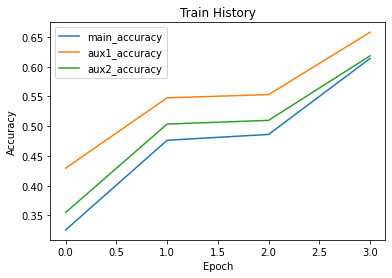

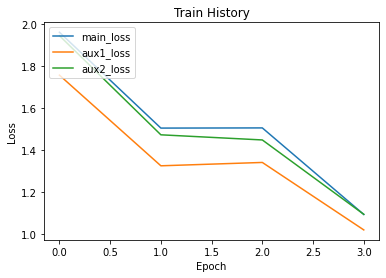

In [40]:

def show_train_history(history, xlabel, ylabel, train):
    for item in train:
        plt.plot(history[item])
    plt.title('Train History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

show_train_history(history_all, 'Epoch', 'Accuracy', ('main_accuracy', 'aux1_accuracy', 'aux2_accuracy'))
show_train_history(history_all, 'Epoch', 'Loss', ('main_loss', 'aux1_loss', 'aux2_loss'))
